# Data Quality

This notebook shows some of the data quality functions associated with a {py:class}`Spectrum <dysh.spectra.spectrum.Spectrum>`. The data used for this example is taken from position switched observations of NGC5291 at 21 cm (AGBT05B_047_01).

The following {py:class}`Spectrum <dysh.spectra.spectrum.Spectrum>` functions will be discussed:

* {py:class}`stats <dysh.spectra.spectrum.Spectrum.stats>` : statistics of a spectrum
* {py:class}`roll <dysh.spectra.spectrum.Spectrum.roll>` : subtract the data by its rolled version to discover channel correlations and/or ripples in the spectrum
* {py:class}`radiometer <dysh.spectra.spectrum.Spectrum.radiometer>` : adherence of spectrum to the radiometer equation
* {py:class}`normalness <dysh.spectra.spectrum.Spectrum.normalness>` : p-value for null hypothesis that the data comes from a normal distribution
* {py:class}`snr <dysh.spectra.spectrum.Spectrum.snr>` : signal-to-noise ratio, either channel or flux based
* {py:class}`sratio <dysh.spectra.spectrum.Spectrum.sratio>` : flux ratio, a number between -1 and 1, if there is signal, 0 if none
* {py:class}`cog <dysh.spectra.spectrum.Spectrum.cog>` : curve of growth

<!--
```
stats         - statistics of a spectrum
roll          - a series of rolls (1,2,3...) to discover channel correlations and/or ripples in the spectrum
radiometer    - adherence of spectrum to the radiometer equation
snr           - signal/noise ratio, either channel or flux based
sratio        - flux ratio, an indiction of a number between -1 and 1, if there is signal, 0 if none.
normalness    - likelyhood noise is a gaussian, returned as a p-value  (p>0.05 means signal is gaussian(
cog           - curve of growth - can be useful to automatically determine where signal is
```
-->
## Loading Modules

We start by loading the modules we will use in this notebook. 

For display purposes, we use the static (non-interactive) `matplotlib` backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on `jupyter` lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl # Uncomment for interactive plots.

# These modules are required for the data reduction.
import numpy as np
from astropy import units as u
from dysh.util.files import dysh_data
from dysh.spectra.spectrum import Spectrum
from dysh.fits.gbtfitsload import GBTFITSLoad

from dysh.log import init_logging

In [2]:
# Set logging to INFO level.
# This is only required in notebooks.
init_logging(2)

## Data Loading

We use the data from the tests for {py:class}`getps <dysh.fits.gbtfitsload.GBTFITSLoad.getps>` (AGBT05B_047_01).
We load the data using {py:class}`GBTFITSLoad <dysh.fits.gbtfitsload.GBTFITSLoad>`, and then its {py:class}`summary <dysh.fits.gbtfitsload.GBTFITSLoad.summary>` method to inspect its contents.

In [3]:
filename = dysh_data(test="getps")      # AGBT05B_047_01/AGBT05B_047_01.raw.acs
sdfits = GBTFITSLoad(filename)

In [4]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.3431,18.6427
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.9306,18.7872
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.3305,18.3561
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.9157,18.4927
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.3042,18.0575
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.8906,18.1860
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.3275,17.3853
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.9192,17.4949


## Data Reduction

First we extract a (time-averaged) spectrum from the first scan. 
If you recall from the [Position-Switched example](https://dysh.readthedocs.io/en/latest/tutorials/examples/positionswitch.html), both edges have some problems, and for the purpose of this we remove some edge channels by slicing the {py:class}`Spectrum <dysh.spectra.spectrum.Spectrum>`. 
We end by plotting the resulting {py:class}`Spectrum <dysh.spectra.spectrum.Spectrum>` using channels for the x-axis.

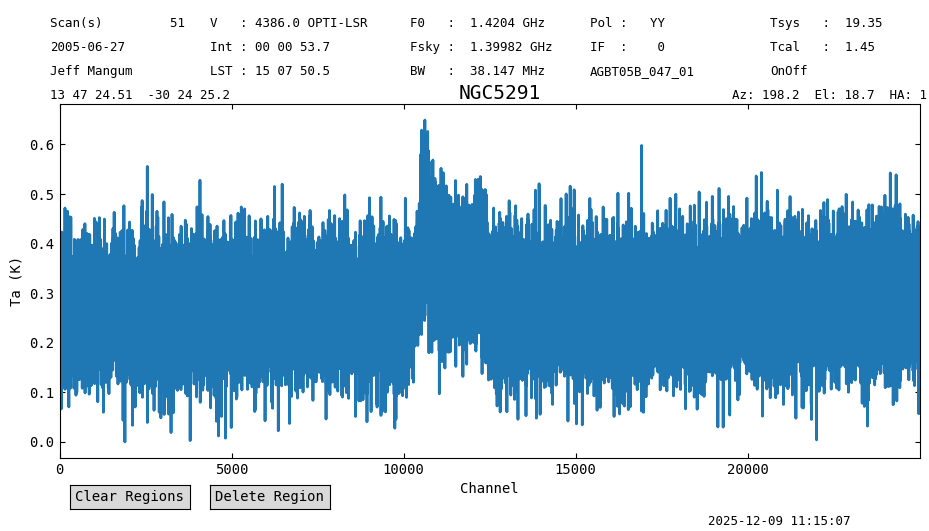

In [5]:
sp1 = sdfits.getps(scan=51, ifnum=0, plnum=0, fdnum=0).timeaverage()[5000:30000]
plot1 = sp1.plot(xaxis_unit='chan');

From the plot we see that there is a clear signal between channels 10000 and 13000.
We will avoid these channels in some of the examples below to reduce their impact on the computed data quality metrics.

## Statistics
We start by showing the use of the {py:class}`stats <dysh.spectra.spectrum.Spectrum.stats>` method.
This computes the mean, median, rms, mininum, maximum, number of points and number of points that are not-a-number (NaN).
We can compute these statistics over a subset of channels by slicing the {py:class}`Spectrum <dysh.spectra.spectrum.Spectrum>` before calling the method.
We do this for the first 10000 channels and the last 10000 channels.

In [6]:
# First 10,000 channels.
sp1[:10000].stats()

{'mean': <Quantity 0.26528673 K>,
 'median': <Quantity 0.26475095 K>,
 'rms': <Quantity 0.07121472 K>,
 'min': <Quantity 0.00017927 K>,
 'max': <Quantity 0.55562309 K>,
 'npt': 10000,
 'nan': np.int64(0)}

In [7]:
# Last 10,000 channels.
sp1[-10000:].stats()

{'mean': <Quantity 0.28550266 K>,
 'median': <Quantity 0.28676712 K>,
 'rms': <Quantity 0.07194848 K>,
 'min': <Quantity 0.00420958 K>,
 'max': <Quantity 0.59789101 K>,
 'npt': 10000,
 'nan': np.int64(0)}

There is a significant continuum visible in the spectrum, with a value of ${\approx}270$ mK.

The rms levels are very similar, at 0.0712 K and 0.0719 K respectively.

It is possible to compute the statistics over a "rolled" version of the spectrum.
That is, before computing the statistics, the values from channel `i+roll` are subtracted from the values of channel `i`.
This accomplished using the `roll` argument in the call to {py:class}`stats <dysh.spectra.spectrum.Spectrum.stats>`.
When using ``roll!=0`` the rms is divided by $\sqrt{2}$ to account for the subtraction.

In [8]:
print(sp1[:10000].stats(roll=2)["rms"])
print(sp1[-10000:].stats(roll=2)["rms"])

0.07129852680478319 K
0.07117563979673235 K


## Roll

The {py:class}`roll <dysh.spectra.spectrum.Spectrum.roll>` method compares the rms in the spectrum to the rms obtained after "rolling" the data by `roll` channels.
This method is useful for assessing if there are channel-to-channel correlations. In the abscence of correlations the result should be close to unity. 
Correlations will drive the results away from unity.
However, the results from {py:class}`roll <dysh.spectra.spectrum.Spectrum.roll>` are also affected by slow variations in the data, as is the case with this spectrum.
We thus compare the first and second half.

In [9]:
sp1[:10000].roll(4)

[np.float64(1.0135264184344186),
 np.float64(0.998824594091855),
 np.float64(1.0009603155106295),
 np.float64(1.0088321963615878)]

In [10]:
sp1[-10000:].roll(4)

[np.float64(0.9999156099029664),
 np.float64(1.0108582257308134),
 np.float64(1.0084001989693765),
 np.float64(0.9975490048638298)]

Here one can argue there is no correllation between channels, and there is little variation in the baseline.

##  Radiometer Equation

For a given $T_{sys}$, channel width $\Delta f$ and observing time $\Delta t$ the radiometer equation predicts the expected noise as:
$$
  \Delta T = {  { T_{sys} } \over \sqrt{ \Delta f \Delta t } }
$$
The {py:class}`radiometer <dysh.spectra.spectrum.Spectrum.radiometer>` method will return the ratio of the measured noise to this expected noise.
In the abscence of artifacts, the result should be unity.
Deviations from unity might indicate that the noise properties do not follow those of a normal distribution.

For example, if we blindly compute this test we will get a value larger than one, because of the line between channels 10000 and 13000.

In [11]:
sp1.radiometer()

np.float64(1.1252550964360961)

When we compute it on line-free channels the results are closer to unity.

In [12]:
print(sp1[:10000].radiometer(), sp1[-10000:].radiometer())

1.0534482574016264 1.064302431580704


However, the measured noise (rms) is still ${\approx}6\%$ larger than expected.

For comparison, we compute this statistic in the case of a purely Gaussian signal.
We do this using the {py:class}`fake_spectrum <dysh.spectra.spectrum.Spectrum.fake_spectrum>` method, which returns a spectrum filled with Gaussian noise.

In [13]:
Spectrum.fake_spectrum(nchan=32768, seed=123).radiometer()

np.float64(1.000493959432403)

The exact value is a function of the number of channels in the spectrum, and it goes as $1/\sqrt{N}$. 
Experiments showed that for nchan=32768 the rms in this ratio is about 0.004, as seen in the above code.

## Normalness

The {py:class}`normalness <dysh.spectra.spectrum.Spectrum.normalness>` method gives the likelihood that the spectrum data is drawn from a normal distribution.
Under the hood this method computes the Anderson-Darling statistic and returns the p-value of the likelihood that the data is normally distributed.
A p-value larger than 0.05 indicates that the data is consistent with being drawn from a normal distribution.

We start by computing the normalness test for the line-free regions, and then we compute it for the whole spectrum.

In [14]:
print(sp1[:10000].normalness())
print(sp1[-10000:].normalness())

0.598849482951862
0.3155802929161549


These values are larger than 0.05, so the line-free regions are consistent with Gaussian noise.
Now the whole spectrum.

In [15]:
print(sp1.normalness())

2.577911948763439e-09


In this case the p-value is lower than 0.05, indicating that the null-hyphotesis can be rejected, that is, the data is not drawn from a normal distribution.
That is the case because of the line between channels 10000 and 13000.

## Baseline Subtraction

The remaining data quality tests, the signal-to-noise ratio and signal ratio, only make sense if the data has no continuum.
In this case that requires subtracting a baseline from the data.

We know that there is a line between channels 10000 and 13000, so we exclude these channels from the baseline fit using the `exclude` argument of {py:class}`Spectrum.baseline <dysh.spectra.spectrum.Spectrum.baseline>`.
We saw earlier that there's a slope to the data, so we use a degree 1 polynomial for the baseline model.
We remove the best fit polynomial model from the data (`remove=True`).

In [16]:
sp1.baseline(degree=2, model="poly", exclude=[10000,13000], remove=True)

11:15:11.537 I EXCLUDING [Spectral Region, 1 sub-regions:
  (1397351017.8086 Hz, 1401928654.52735 Hz) 
]


Plot the baseline subtracted spectrum and print its statistics.

{'mean': <Quantity 0.00742555 K>, 'median': <Quantity 0.00620263 K>, 'rms': <Quantity 0.07572969 K>, 'min': <Quantity -0.28504302 K>, 'max': <Quantity 0.37799224 K>, 'npt': 25000, 'nan': np.int64(0)}


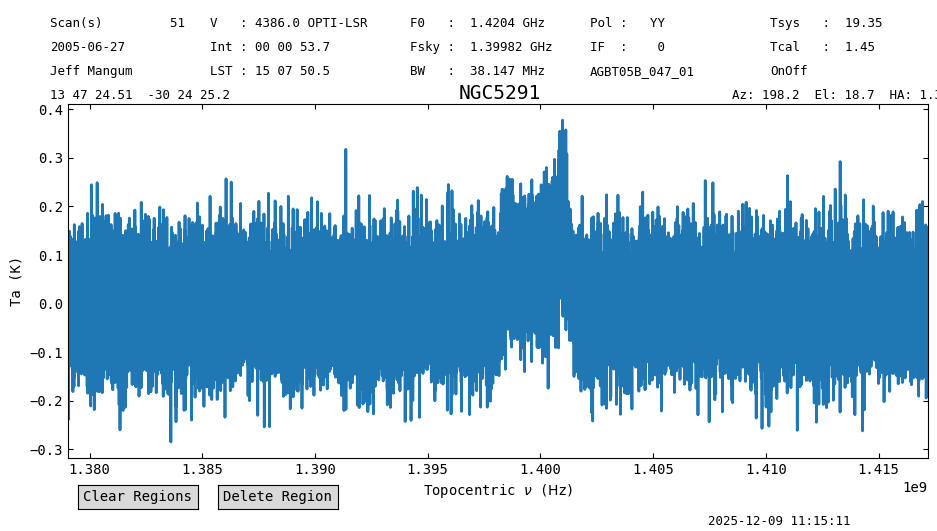

In [17]:
sp1.plot();
print(sp1.stats())

## snr: Signal-to-Noise Ratio

The {py:class}`snr <dysh.spectra.spectrum.Spectrum.snr>` method computes the signal-to-noise ratio of the spectrum.
This can be done in two ways: channel based and flux based.
For the latter a section of the spectrum where the signal is expected has to be selected.
For the channel based analysis, it will compute the ratio between the maximum value (``peak=True``, default) and the noise.
For an absorption signal one can use ``peak=False``.

For pure noise in a channel based comparision (the default) we would expect the signal-to-noise to be around 4, higher for higher number of channels, as can be computed via the error function.

In [18]:
print(sp1[:10000].snr(), sp1[-10000:].snr())

4.164491209380743 4.418897606868031


Now we repeat the ``snr`` call, but using the flux instead.
We show the results for the line-free regions of the spectrum and for the section with the line.

In [19]:
print(sp1[:10000].snr(flux=True))
print(sp1[-10000:].snr(flux=True))
print(sp1[10000:13000].snr(flux=True))

-0.032206540254441474
-0.31387167706379776
47.65735422463844


The line-free regions have a signal-to-noise of $<0.5$, so no signal in them.
Channels 10000 to 13000 have a signal-to-noise ratio of $47$.

## sratio:  Signal Ratio

The signal ratio is defined as the sum between the positive and negative sum of the signals, normalized by the difference of both. This results in a dimensionless number between -1 and 1, where -1 means a pure absorption signal, 0 pure noise, and 1 pure emission line:
$$
     S_r = {{ P_{sum}+ N_{sum} } \over {P_{sum} - N_{sum}}}
$$
with $P_{sum}$ the sum of all the channels with positive values and $N_{sum}$ the sum of all the channels with negative values.
Note that $N_{sum}$ is negative.

We compute this for the line-free channels, where we expect values close to zero (no signal).

In [20]:
print(sp1[:10000].sratio())

-0.000399268816406737


In [21]:
print(sp1[-10000:].sratio())

-0.003947589621889838


And now the channels with the line.

In [22]:
print(sp1[10000:13000].sratio())

0.7404518589686879


In this case we have a value of $0.74$, close to unity, indicating an emission line.

## Repeat statistics, roll and radiometer

Now that the spectrum has been baseline subtracted we can repeat the analysis carried out above.

In [23]:
# redo the tests
print(sp1[:10000].stats())
print(sp1[:10000].stats(roll=1))
print("ROLL",sp1[:10000].roll(4))


print(sp1[-10000:].stats())
print(sp1[-10000:].stats(roll=1))
print("ROLL",sp1[-10000:].roll(4))

{'mean': <Quantity -2.26296993e-05 K>, 'median': <Quantity -0.00075626 K>, 'rms': <Quantity 0.07116939 K>, 'min': <Quantity -0.26237536 K>, 'max': <Quantity 0.29259242 K>, 'npt': 10000, 'nan': np.int64(0)}
{'mean': <Quantity -1.91970331e-06 K>, 'median': <Quantity -0.00102835 K>, 'rms': <Quantity 0.0702643 K>, 'min': <Quantity -0.37160137 K>, 'max': <Quantity 0.35925086 K>, 'npt': 9998, 'nan': np.int64(0)}
ROLL [np.float64(1.0128811836035871), np.float64(0.9981887196390057), np.float64(1.0003230829955267), np.float64(1.0081899539027515)]
{'mean': <Quantity -0.00022584 K>, 'median': <Quantity 0.00077847 K>, 'rms': <Quantity 0.071728 K>, 'min': <Quantity -0.28504302 K>, 'max': <Quantity 0.31773396 K>, 'npt': 10000, 'nan': np.int64(0)}
{'mean': <Quantity 1.49875702e-05 K>, 'median': <Quantity 7.21955806e-06 K>, 'rms': <Quantity 0.07195455 K>, 'min': <Quantity -0.36167572 K>, 'max': <Quantity 0.36903475 K>, 'npt': 9998, 'nan': np.int64(0)}
ROLL [np.float64(0.9968514885721491), np.float64(1

In [24]:
print(sp1[:10000].radiometer(), sp1[-10000:].radiometer())

1.052777606911913 1.0610410041607696


Curious how the radiometer equation holds as function of time?

In [25]:
for scan in [51,53,55,57]:
    sp2 = sdfits.getps(scan=scan, ifnum=0, plnum=0, fdnum=0).timeaverage()[5000:30000]
    print(scan, sp2[:10000].radiometer(), sp2[-10000:].radiometer())

51 1.0534482574016264 1.064302431580704
53 1.040350406935904 1.0625100007245583
55 1.0583714842277552 1.0546632159969935
57 1.0434732937008275 1.0579653655733117


So we can conclude it did not change behavior during this observation, but there is a clean 5% deviation from an ideal telescope.

## Smoothing

Smoothing should give us a much clearer detection.
We smooth the data using a Hanning kernel with a width of 50 channels.
Lets see how the previous measures live of to this task.

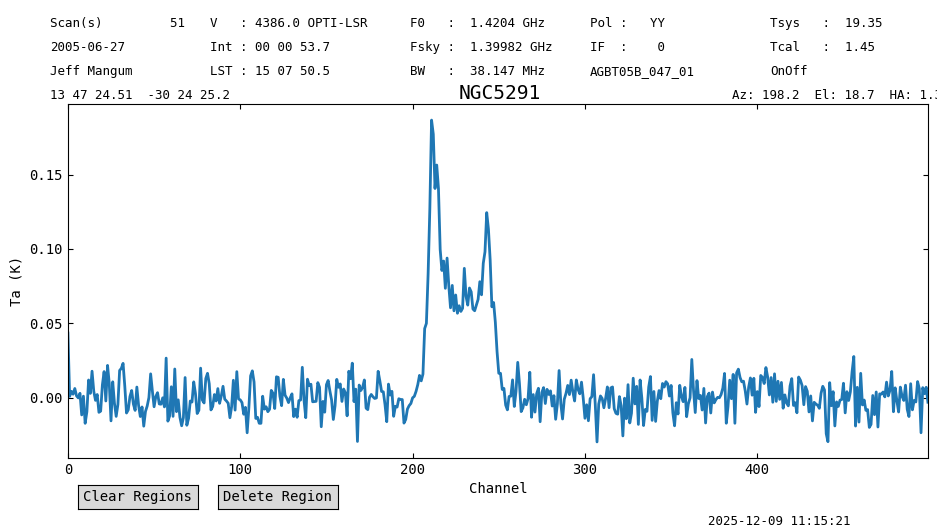

In [26]:
n = 50
sp1s = sp1.smooth('hanning', n)
sp1s.plot(xaxis_unit='chan')

The line is now between channels 200 and 260.

Lets print the rms for this smoothed signal. 
Unsmoothed we found 0.07 K so we should expect $\sqrt{50}$ better, or about 0.01 K.

In [27]:
print(sp1s[:200].stats()["rms"], sp1s[-200:].stats()["rms"])

0.010752784984015664 K 0.010549863785047879 K


Smoothing reduced the noise as expected.

Now the radiometer equation test.

In [28]:
print(sp1s[:200].radiometer())
print(sp1s[-200:].radiometer())

1.1247328739459044
1.1035074757222016


In this case the test suggests that the data is worse than before (it was $5\%$ higher, now it is $11\%$).
This could be an artifact of ``dysh``.

Now the signal-to-noise ratio.

In [29]:
print(sp1s[:200].snr(peak=True), sp1s[:200].snr(peak=False), 'left side')
print(sp1s[-200:].snr(peak=True), sp1s[-200:].snr(peak=False), 'right side')
print(sp1s[200:260].snr(peak=True), sp1s[200:260].snr(peak=False), 'signal portion')

4.484230565824742 3.0157797607093038 left side
2.641517296843382 2.798766304762895 right side
9.702435844984779 5.432313027221527 signal portion


In [30]:
print(sp1s[:200].snr(flux=True), 'left side')
print(sp1s[-200:].snr(flux=True), 'right side')
print(sp1s[200:260].snr(flux=True), 'signal portion')

-0.154500225840378 left side
-0.24202494585771142 right side
37.169404072966664 signal portion


Notice that the signal-to-noise in the line intensity is now lower than before (it was ${\approx}47$).
That is because the ``snr`` method uses the data itself to determine the noise.
Since we are using a channel range that mostly contains signal, the noise estimate is higher, thus reducing the signal-to-noise ratio.
We can give our own estimate of the noise using the ``rms`` parameter when calling ``snr``.
Like

In [31]:
print(sp1s[200:260].snr(flux=True, rms=sp1s[-200:].stats()["rms"]), 'signal portion')

45.34448732737642 signal portion


This is closer to the previous estimate.
It also shows that smoothing the data does not improve the signal-to-noise ratio on the line intensity for this velocity resolved line.

And the signal ratio.

In [32]:
sp1s[200:260].sratio()

np.float64(0.9898058259803745)

## Curve of Growth

The [Curve of Growth method](https://dysh.readthedocs.io/en/latest/explanations/cog/index.html) ([Yu et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...898..102Y/abstract)) also lists lots of interesting properties that can be used in some of the quality assessment functions we have discussed above.

In [33]:
sp1s.cog()

{'flux': <Quantity 60.7548381 K km / s>,
 'flux_std': <Quantity 1.67196758 K km / s>,
 'flux_r': <Quantity 29.4009652 K km / s>,
 'flux_r_std': <Quantity 1.94644775 K km / s>,
 'flux_b': <Quantity 31.41728474 K km / s>,
 'flux_b_std': <Quantity 1.46281975 K km / s>,
 'width': {0.25: <Quantity 215.4868403 km / s>,
  0.65: <Quantity 447.54977747 km / s>,
  0.75: <Quantity 513.85353672 km / s>,
  0.85: <Quantity 580.15733259 km / s>,
  0.95: <Quantity 679.61310541 km / s>},
 'width_std': {0.25: <Quantity 33.22178748 km / s>,
  0.65: <Quantity 16.80630176 km / s>,
  0.75: <Quantity 33.54775629 km / s>,
  0.85: <Quantity 33.65571145 km / s>,
  0.95: <Quantity 33.8413805 km / s>},
 'A_F': np.float64(1.068580045741498),
 'A_C': np.float64(1.2116639031279515),
 'C_V': np.float64(2.692309803187622),
 'rms': <Quantity 0.01055038 K>,
 'bchan': np.int64(185),
 'echan': np.int64(267),
 'vel': <Quantity 4382.45068039 km / s>,
 'vel_std': <Quantity 440.84330695 km / s>}